# From Introduction to Dask

### By Paul Hendricks

https://github.com/rapidsai-community/notebooks-contrib/blob/main/getting_started_materials/intro_tutorials_and_guides/03_Introduction_to_Dask.ipynb 


In [1]:
import dask
from dask.distributed import Client, LocalCluster
from dask import delayed
import time 
from dask.distributed import wait
import graphviz


### Introduction to Dask

Dask is a library the allows for parallelized computing. 
It allows one to compose complex workflows using large data structures like those found in NumPy, Pandas, and cuDF. 


### Client/Workers

Dask operates by creating a cluster composed of a "client" and multiple "workers". 

The client is responsible for scheduling work.

The workers are responsible for actually executing that work.

Typically, we set the number of workers to be equal to the number of computing resources we have available to us.

For CPU based workflows, this might be the number of cores or threads on that particlular machine. 

For example, we might set n_workers = 8 if we have 8 CPU cores or threads on our machine that can each operate in parallel. 

This allows us to take advantage of all of our computing resources and enjoy the most benefits from parallelization.

On a system with one or more GPUs, we usually set the number of workers equal to the number of GPUs available to us. 

Dask is relevant in the world of GPU computing and the RAPIDS ecosystem makes it very easy to use Dask with cuDF and XGBoost.



We need to setup a Local Cluster of workers to execute our work and a Client to coordinate and schedule work for that cluster. 

As we see below, we can inititate a cluster and client using only few lines of code.

Here, we create a local cluster with 4 workers

In [2]:
n_workers = 4
cluster = LocalCluster(n_workers=n_workers)
client = Client(cluster)


Let's inspect the client object to view our current Dask status. 

We should see the IP Address for our Scheduler as well as the the number of workers in our Cluster.


In [3]:
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 32,Total memory: 482.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39805,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 482.42 GiB
Comm: tcp://127.0.0.1:40471,Total threads: 8
Dashboard: http://127.0.0.1:44649/status,Memory: 120.61 GiB
Nanny: tcp://127.0.0.1:34809,


Next, we'll iterate through our n_workers and create an execution graph, 

Each worker is responsible for taking its ID and passing it to the function add_5_to_x. 

For example, the worker with ID 2 will take its ID and pass it to the function add_5_to_x, resulting in the value 7.

We define a function called add_5_to_x that takes some value x and adds 5 to it.

In [4]:
def add_5_to_x(x):
    return x + 5
    

In [5]:
addition_operations = [delayed(add_5_to_x)(i) for i in range(n_workers)]
addition_operations


[Delayed('add_5_to_x-5d341821-80ca-43ff-aa5b-d6d902fc97d6'),
 Delayed('add_5_to_x-f025d69a-d23e-479d-a262-1da3d845d8f2'),
 Delayed('add_5_to_x-724ecdca-8d21-4c8d-b60b-86db1a0e7595'),
 Delayed('add_5_to_x-a31ab865-c4b9-41ec-ac25-f04252b9c9ab')]

The above output shows a list of several Delayed objects!

An important thing to note is that the workers aren't actually executing these results!

We're just defining the execution graph for our client to execute later.

The delayed function wraps our function add_5_to_x and returns a Delayed object.

This ensures that this computation is in fact "delayed" and not executed on the spot (lazily evaluation).


Next, let's sum each one of these intermediate results.

We can accomplish this by wrapping Python's built-in sum function.

We use our delayed function and store this in a variable called total.
    

In [6]:
total = delayed(sum)(addition_operations)
total


Delayed('sum-f6422d05-8bc1-4458-8295-7a1246a0267e')

Using the graphviz library, we can use the visualize method of a Delayed object to visualize our current graph.

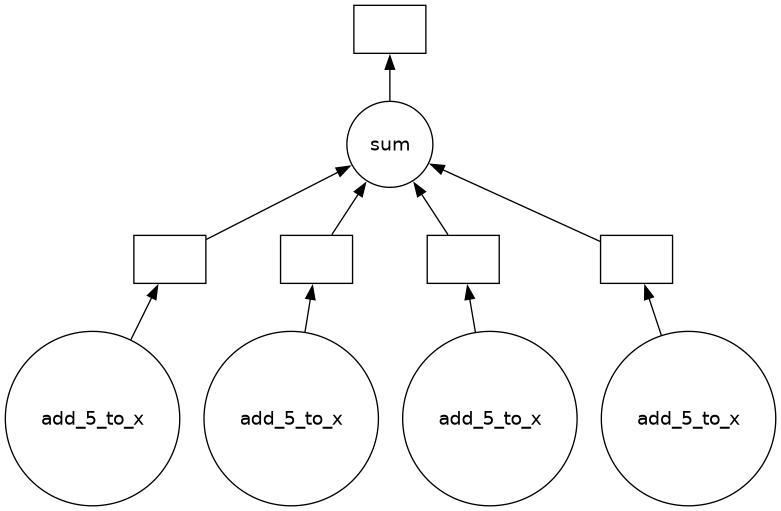

In [7]:
total.visualize()

The above output shows again a Delayed objects!

As we mentioned before, none of these results - intermediate or final - have actually been compute. 

We can compute them using the compute method of our client.


In [8]:
addition_futures = client.compute(addition_operations, optimize_graph=False, fifo_timeout="0ms")
addition_futures


[<Future: pending, key: add_5_to_x-5d341821-80ca-43ff-aa5b-d6d902fc97d6>,
 <Future: pending, key: add_5_to_x-f025d69a-d23e-479d-a262-1da3d845d8f2>,
 <Future: pending, key: add_5_to_x-724ecdca-8d21-4c8d-b60b-86db1a0e7595>,
 <Future: pending, key: add_5_to_x-a31ab865-c4b9-41ec-ac25-f04252b9c9ab>]

We can see from the above output that our addition_futures variable is a list of Future objects

It is not the "actual results" of adding 5 to each of [0, 1, 2, 3]. 

These Future objects are a promise that at one point a computation will take place and we will be left with a result.

Dask is responsible for fulfilling that promise by delegating that task to the appropriate Dask worker and collecting the result.

Let's take a look at our total_future object:


In [9]:
total_future = client.compute(total, optimize_graph=False, fifo_timeout="0ms")
wait(total_future)  # this will give Dask time to execute the work
total_future


<Future: finished, type: int, key: sum-f6422d05-8bc1-4458-8295-7a1246a0267e>

In [10]:
type(total_future)


distributed.client.Future

total_future is a Future with status of the request, type of the result, and a key associated with the operation

To collect and print the result of each of these Future objects, we can call the result() method


In [11]:
addition_results = [future.result() for future in addition_futures]
addition_results


[5, 6, 7, 8]

Now we see the results that we want from our addition operations.

We can also use the simpler syntax of the client.gather method to collect our results.
    

In [12]:
addition_results = client.gather(addition_futures)
addition_results


[5, 6, 7, 8]

In [13]:
total_result = client.gather(total_future)
total_result


26

Awesome! We just wrote our first distributed workflow.

To confirm that Dask is truly executing in parallel

Consider a function that sleeps for 1 second and returns the string "Success!"


In [14]:
def sleep_1():
    time.sleep(1)
    return 'Success!'


In serial, this function should take our 4 workers around 4 seconds to execute.


In [15]:
start = time.time()
for _ in range(n_workers):
    sleep_1()
dt = time.time() - start
print(f"dt = {dt}")

dt = 4.000440835952759


As expected, our process takes around 4 seconds to run

Now let's execute this same workflow in parallel using Dask


In [16]:
# define delayed execution graph
start = time.time()
sleep_operations = [delayed(sleep_1)() for _ in range(n_workers)]
# use client to perform computations using execution graph
sleep_futures = client.compute(sleep_operations, optimize_graph=False, fifo_timeout="0ms")
# collect and print results
sleep_results = client.gather(sleep_futures)
dt = time.time() - start


In [17]:
print(sleep_results)
print(f"dt = {dt}")

['Success!', 'Success!', 'Success!', 'Success!']
dt = 1.0088496208190918


Using Dask, we see that this whole process takes around 1 second - each worker is executing in parallel!


In [18]:
client.close()
